<a href="https://www.kaggle.com/code/avtnshm/clinical-modernbert-v-biomedicalmb-on-ddxplus-data?scriptVersionId=288347292" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A comparison paper between two ModernBERT Models- Clinical MB  & BioMedicalMB


### Introduction to the Models and Dataset used
#### ModernBERT is a new model series that is a Pareto improvement over BERT and its younger siblings across both speed and accuracy (arxiv.org/abs/2412.13663)

#### BioClinical ModernBERT- a domain-adapted encoder that builds on the recent ModernBERT release, incorporating long-context processing and substantial improvements in speed and performance for biomedical and clinical NLP.(arxiv.org/abs/2506.10896)

#### Clinical ModernBERT - encoder pretrained on large scale biomedical literature, clinical notes, and medical ontologies, incorporating PubMed abstracts, MIMIC IV clinical data, and medical codes with their textual descriptions. Building on ModernBERT...(arxiv.org/abs/2504.03964)

#### DDXPlus - a large-scale synthetic dataset of roughly 1.3 million patients that includes a differential diagnosis, along with the ground truth pathology, symptoms and antecedents for each patient.(arxiv.org/abs/2205.09148)

### Literature Review -
- The above mentioned Models are encoder based models based on ModernBERT model, which itself is a improvement on the classic BERT released by Google in 2018, both bioclinical and clinical MB models have extended the context length and trained the MB on plethora of medical datsets. 
- This paper aims to compare the performance of the two said models against each other on DDXPLus dataset and present the results with interpretation.

### Aim of the Notebook Paper
#### The objective of this Kaggle NB running on GPU Tx2 is to compare the performance of the above two models on the DDXPlus and tabulate and present the data in easily readabel format.

### Methodlogy -
- First we load the large DDXPlus dataset into given train, test and validate datasets and also load the evidences json in dataset form.
- Then the Models are loaded from transformers library and used to generate embeddings from the 30 per cent of the dataset as 1.2 M is quite a large number computationally, for one, the working memory of Kaggle NB is ~20G, but the embeddings genearte will need more storage space than that, thus the stratified sampling.
- We then visulaize the generated embeddings using the embeddings space and t-SNE plots
- Then comes the downstream evaluation tasks, using first a logistic regression model and then a more intricate MLPClassifier Model.
- Finally, we compare the top-k scores, accuracy and general text evaulation for both the models and tabluate and try to understand the results obtained.

### Loading and reading the DDXPlus Dataset

In [1]:
# Step 1: Load Data

import pandas as pd
import numpy as np
import json

train_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/train.csv')
test_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/test.csv')
validate_df = pd.read_csv('/kaggle/input/mldataset/ddxplus/validate.csv')

print(train_df.shape, validate_df.shape, test_df.shape)

(1025602, 6) (132448, 6) (134529, 6)


In [2]:
with open('/kaggle/input/mldataset/ddxplus/release_evidences.json') as f:
    evidences = json.load(f)

evidences_df = pd.DataFrame.from_dict(evidences, orient='index')

#### Checking the datasets

In [3]:
train_df.head(5)

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumo...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54...",E_91
1,21,"[['HIV (initial infection)', 0.518950056440760...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_...",E_50
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumo...",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55...",E_77
3,34,"[['URTI', 0.23859396799565236], ['Cluster head...",F,URTI,"['E_48', 'E_53', 'E_54_@_V_183', 'E_55_@_V_89'...",E_53
4,36,"[['URTI', 0.23677812769175735], ['Influenza', ...",M,URTI,"['E_49', 'E_50', 'E_53', 'E_54_@_V_183', 'E_55...",E_201


In [4]:
evidences_df.head(5)

,name,code_question,question_fr,question_en,is_antecedent,default_value,value_meaning,possible-values,data_type
E_91,E_91,E_91,Avez-vous objectivé ou ressenti de la fièvre?,Do you have a fever (either felt or measured w...,False,0,{},[],B
E_55,E_55,E_53,Avez-vous de la douleur quelque part?,Do you feel pain somewhere?,False,V_123,"{'V_123': {'fr': 'nulle part', 'en': 'nowhere'...","[V_123, V_14, V_15, V_16, V_17, V_18, V_19, V_...",M
E_53,E_53,E_53,Avez-vous de la douleur à quelque part en lien...,"Do you have pain somewhere, related to your re...",False,0,{},[],B
E_57,E_57,E_53,Est-ce que la douleur se propage vers un autre...,Does the pain radiate to another location?,False,V_123,"{'V_123': {'fr': 'nulle part', 'en': 'nowhere'...","[V_123, V_14, V_15, V_16, V_17, V_18, V_19, V_...",M
E_54,E_54,E_53,Caractérisez votre douleur:,Characterize your pain:,False,V_11,"{'V_11': {'fr': 'NA', 'en': 'NA'}, 'V_71': {'f...","[V_11, V_71, V_112, V_154, V_161, V_179, V_180...",M


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025602 entries, 0 to 1025601
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   AGE                     1025602 non-null  int64 
 1   DIFFERENTIAL_DIAGNOSIS  1025602 non-null  object
 2   SEX                     1025602 non-null  object
 3   PATHOLOGY               1025602 non-null  object
 4   EVIDENCES               1025602 non-null  object
 5   INITIAL_EVIDENCE        1025602 non-null  object
dtypes: int64(1), object(5)
memory usage: 46.9+ MB


#### Observations - we see that the train dataset from DDXPlus datasets has over a million non null values of patients, namely, age, ddx, gender, pathology, evidences and initial eviences, we also observe that evidences dataset has meaningful relationships defined for pathology and evidences in the form of question, antecedent, value meaning and possobile as seen below-

In [6]:
evidences_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, E_91 to E_5
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             223 non-null    object
 1   code_question    223 non-null    object
 2   question_fr      223 non-null    object
 3   question_en      223 non-null    object
 4   is_antecedent    223 non-null    bool  
 5   default_value    223 non-null    object
 6   value_meaning    223 non-null    object
 7   possible-values  223 non-null    object
 8   data_type        223 non-null    object
dtypes: bool(1), object(8)
memory usage: 15.9+ KB


In [7]:
def codes_to_text(evidence_str):
    if not isinstance(evidence_str, str):
        return ""
    parts = [c.strip() for c in evidence_str.split(";")]
    mapped = [evidences_df.loc[p, "question_en"] for p in parts if p in evidences_df.index]
    return " ".join(mapped)

In [8]:
train_df["TEXT"] = train_df["EVIDENCES"].apply(codes_to_text)
validate_df["TEXT"] = validate_df["EVIDENCES"].apply(codes_to_text)
test_df["TEXT"] = test_df["EVIDENCES"].apply(codes_to_text)

#### Stratifying the Dataset to 30 per cent due to its large size and GPU constraints

In [9]:
from sklearn.model_selection import train_test_split

train_30, _ = train_test_split(
    train_df,
    test_size=0.70,
    stratify=train_df["PATHOLOGY"],
    random_state=42
)

valid_30, _ = train_test_split(
    validate_df,
    test_size=0.70,
    stratify=validate_df["PATHOLOGY"],
    random_state=42
)

test_30, _ = train_test_split(
    test_df,
    test_size=0.70,
    stratify=test_df["PATHOLOGY"],
    random_state=42
)

print(train_30.shape, valid_30.shape, test_30.shape)

(307680, 7) (39734, 7) (40358, 7)


#### Loading the Models and tokenzier from transformers library

In [10]:
!pip install -q transformers
import torch
from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

cmb_model = AutoModel.from_pretrained('Simonlee711/Clinical_ModernBERT').to(device)
cmb_tok = AutoTokenizer.from_pretrained('Simonlee711/Clinical_ModernBERT')

bmb_model = AutoModel.from_pretrained("thomas-sounack/BioClinical-ModernBERT-base").to(device)
bmb_tok = AutoTokenizer.from_pretrained("thomas-sounack/BioClinical-ModernBERT-base")

Using: cuda


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Simonlee711/Clinical_ModernBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

#### Generating the Embeddings using both the loaded Models

In [11]:
def embed(text_list, tokenizer, model, batch_size=32):
    all_vecs = []

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            out = model(**inputs).last_hidden_state[:,0,:]

        all_vecs.append(out.cpu().numpy())

    return np.vstack(all_vecs)

In [12]:
train_texts = train_30["TEXT"].tolist()
valid_texts = valid_30["TEXT"].tolist()
test_texts  = test_30["TEXT"].tolist()

cmb_train = embed(train_texts, cmb_tok, cmb_model)
bmb_train = embed(train_texts, bmb_tok, bmb_model)

W1225 07:44:06.236000 38 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


In [13]:
!pip install umap-learn -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
import numpy as np
import pandas as pd

# Number of samples for visualization
N = 5000

# Random indices
idx = np.random.choice(len(train_30), size=N, replace=False)

cmb_vis = cmb_train[idx]
bmb_vis = bmb_train[idx]
labels_vis = train_30["PATHOLOGY"].iloc[idx].values

In [15]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric="cosine")

cmb_2d = reducer.fit_transform(cmb_vis)
bmb_2d = reducer.fit_transform(bmb_vis)

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels_encoded = le.fit_transform(labels_vis)

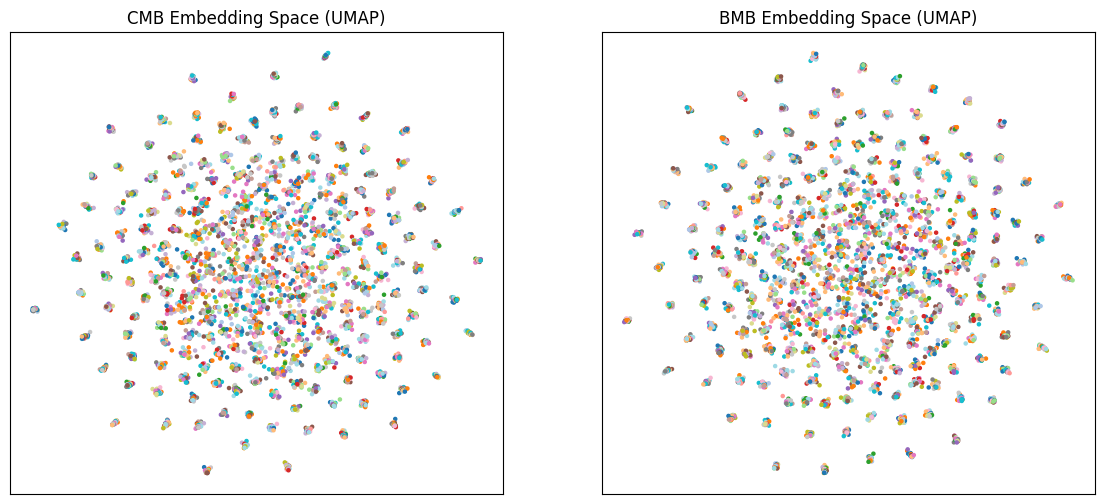

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(cmb_2d[:,0], cmb_2d[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("CMB Embedding Space (UMAP)")
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
plt.scatter(bmb_2d[:,0], bmb_2d[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("BMB Embedding Space (UMAP)")
plt.xticks([]); plt.yticks([])

plt.show()

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    perplexity=50,
    init="pca",
    random_state=42
)

cmb_tsne = tsne.fit_transform(cmb_vis)
bmb_tsne = tsne.fit_transform(bmb_vis)

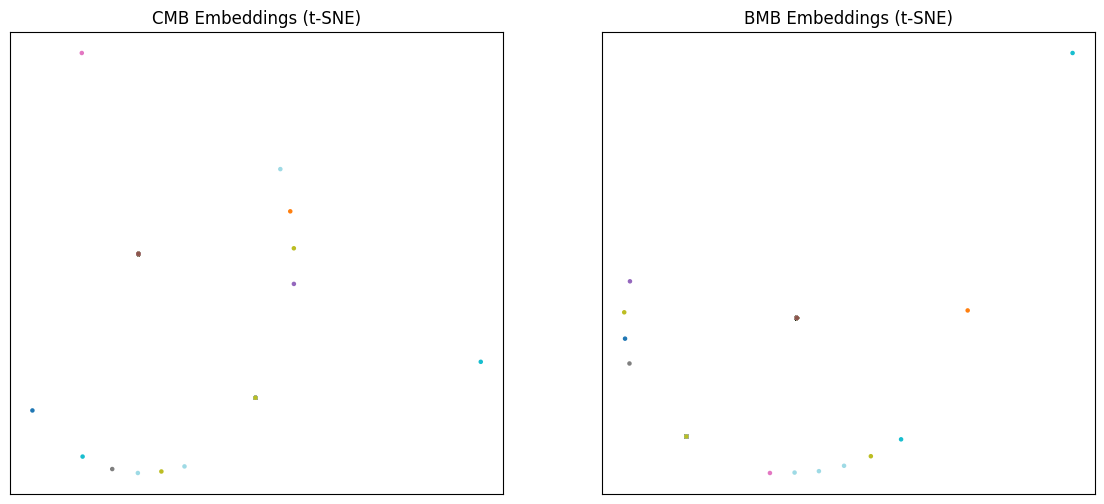

In [19]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.scatter(cmb_tsne[:,0], cmb_tsne[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("CMB Embeddings (t-SNE)")
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
plt.scatter(bmb_tsne[:,0], bmb_tsne[:,1], c=labels_encoded, cmap="tab20", s=5)
plt.title("BMB Embeddings (t-SNE)")
plt.xticks([]); plt.yticks([])

plt.show()

### Visualisation Observations and Remarks

- UMAP and t-SNE projections of the embedding spaces generated by Clinical ModernBERT and BioMedical ModernBERT diplay more or less similar geometric structures.
- In both Models, embeddings related to different pathologies show much overlap, which means that the symptoms can be shared by maladies in differential diagnosis and models are not able to distinguish them.
- No strong class-specific clusters is visible, meaning downstream classification performance depends heavily on the capacity of the classifier rather than geographically separable embedding spaces.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

y_train = train_30["PATHOLOGY"]
y_valid = valid_30["PATHOLOGY"]

clf_cmb = LogisticRegression(max_iter=200)
clf_cmb.fit(cmb_train, y_train)

pred_cmb = clf_cmb.predict(embed(valid_texts, cmb_tok, cmb_model))
print("CMB Macro F1:", f1_score(y_valid, pred_cmb, average='macro'))

CMB Macro F1: 0.0025040750277574354


In [22]:
from sklearn.metrics import top_k_accuracy_score
import pandas as pd

# Clinical ModernBERT + Logistic Regression
clf_cmb = LogisticRegression(max_iter=200)
clf_cmb.fit(cmb_train, y_train)

# BioMedical ModernBERT + Logistic Regression
clf_bmb = LogisticRegression(max_iter=200)
clf_bmb.fit(bmb_train, y_train)

topk = [1, 2, 3, 4, 5]

# Probabilities from Logistic Regression
probs_cmb_lr = clf_cmb.predict_proba(cmb_valid)
probs_bmb_lr = clf_bmb.predict_proba(bmb_valid)

results_lr = []

for k in topk:
    results_lr.append({
        "Model": "Clinical ModernBERT",
        "Classifier": "Logistic Regression",
        "Top-K": k,
        "Accuracy": top_k_accuracy_score(y_valid, probs_cmb_lr, k=k)
    })
    results_lr.append({
        "Model": "BioMedical ModernBERT",
        "Classifier": "Logistic Regression",
        "Top-K": k,
        "Accuracy": top_k_accuracy_score(y_valid, probs_bmb_lr, k=k)
    })

df_lr = pd.DataFrame(results_lr)
df_lr


,Model,Classifier,Top-K,Accuracy
0,Clinical ModernBERT,Logistic Regression,1,0.065360
1,BioMedical ModernBERT,Logistic Regression,1,0.065360
2,Clinical ModernBERT,Logistic Regression,2,0.127624
3,BioMedical ModernBERT,Logistic Regression,2,0.127624
4,Clinical ModernBERT,Logistic Regression,3,0.179745
5,BioMedical ModernBERT,Logistic Regression,3,0.179745
6,Clinical ModernBERT,Logistic Regression,4,0.208839
7,BioMedical ModernBERT,Logistic Regression,4,0.208839
8,Clinical ModernBERT,Logistic Regression,5,0.236724
9,BioMedical ModernBERT,Logistic Regression,5,0.236724


In [26]:
from sklearn.neural_network import MLPClassifier

mlp_cmb = MLPClassifier(hidden_layer_sizes=(256,), max_iter=10)
mlp_cmb.fit(cmb_train, y_train)
pred_cmb_mlp = mlp_cmb.predict_proba(cmb_valid)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
mlp_bmb = MLPClassifier(hidden_layer_sizes=(256,), max_iter=10)
mlp_bmb.fit(bmb_train, y_train)
pred_bmb_mlp = mlp_bmb.predict_proba(bmb_valid)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
from sklearn.neural_network import MLPClassifier

# Clinical ModernBERT + MLP
mlp_cmb = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    max_iter=20,
    random_state=42
)
mlp_cmb.fit(cmb_train, y_train)

# BioMedical ModernBERT + MLP
mlp_bmb = MLPClassifier(
    hidden_layer_sizes=(256,),
    max_iter=5,
    random_state=42
)
mlp_bmb.fit(bmb_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(256,), max_iter=5, random_state=42)

In [29]:
# Probabilities from MLP
probs_cmb_mlp = mlp_cmb.predict_proba(cmb_valid)
probs_bmb_mlp = mlp_bmb.predict_proba(bmb_valid)

results_mlp = []

for k in topk:
    results_mlp.append({
        "Model": "Clinical ModernBERT",
        "Classifier": "MLP",
        "Top-K": k,
        "Accuracy": top_k_accuracy_score(y_valid, probs_cmb_mlp, k=k)
    })
    results_mlp.append({
        "Model": "BioMedical ModernBERT",
        "Classifier": "MLP",
        "Top-K": k,
        "Accuracy": top_k_accuracy_score(y_valid, probs_bmb_mlp, k=k)
    })

df_mlp = pd.DataFrame(results_mlp)
df_mlp


,Model,Classifier,Top-K,Accuracy
0,Clinical ModernBERT,MLP,1,0.065360
1,BioMedical ModernBERT,MLP,1,0.062264
2,Clinical ModernBERT,MLP,2,0.127624
3,BioMedical ModernBERT,MLP,2,0.127624
4,Clinical ModernBERT,MLP,3,0.179745
5,BioMedical ModernBERT,MLP,3,0.179745
6,Clinical ModernBERT,MLP,4,0.207631
7,BioMedical ModernBERT,MLP,4,0.208839
8,Clinical ModernBERT,MLP,5,0.235743
9,BioMedical ModernBERT,MLP,5,0.237177


In [30]:
# Combine both classifiers into one table
df_topk_all = pd.concat([df_lr, df_mlp], ignore_index=True)

# Pivot for clean comparison
comparison_table = df_topk_all.pivot_table(
    index=["Classifier", "Top-K"],
    columns="Model",
    values="Accuracy"
).reset_index()

comparison_table


Model,Classifier,Top-K,BioMedical ModernBERT,Clinical ModernBERT
0,Logistic Regression,1,0.065360,0.065360
1,Logistic Regression,2,0.127624,0.127624
2,Logistic Regression,3,0.179745,0.179745
3,Logistic Regression,4,0.208839,0.208839
4,Logistic Regression,5,0.236724,0.236724
5,MLP,1,0.062264,0.065360
6,MLP,2,0.127624,0.127624
7,MLP,3,0.179745,0.179745
8,MLP,4,0.208839,0.207631
9,MLP,5,0.237177,0.235743


In [36]:
# Pivot into comparison format
df_comp = (
    df_topk_all
    .pivot_table(
        index=["Classifier", "Top-K"],
        columns="Model",
        values="Accuracy"
    )
    .reset_index()
)

# Rename columns for clarity
df_comp = df_comp.rename(columns={
    "Clinical ModernBERT": "Clinical ModernBERT",
    "BioMedical ModernBERT": "BioMedical ModernBERT"
})

# Sort nicely
df_comp = df_comp.sort_values(["Classifier", "Top-K"])

df_comp


Model,Classifier,Top-K,BioMedical ModernBERT,Clinical ModernBERT
0,Logistic Regression,1,0.065360,0.065360
1,Logistic Regression,2,0.127624,0.127624
2,Logistic Regression,3,0.179745,0.179745
3,Logistic Regression,4,0.208839,0.208839
4,Logistic Regression,5,0.236724,0.236724
5,MLP,1,0.062264,0.065360
6,MLP,2,0.127624,0.127624
7,MLP,3,0.179745,0.179745
8,MLP,4,0.208839,0.207631
9,MLP,5,0.237177,0.235743


### Top-K Accuracy Comparison
- We can see that both BMB and CMB Models are producing approximately similar results all through the top-k accuracies.
- As differetial diagnosis involves distinguishing symptoms related to one disease from other and to arrive at concluision of root cause, top-5 and top-3 results can be useful.
- For both models top-3 is around 18 per cent, and top-5 around 24 per cent - indicating that the 

In [31]:
def predict_topk(text, tokenizer, model, clf, k=5):
    vec = embed([text], tokenizer, model)[0].reshape(1,-1)
    probs = clf.predict_proba(vec)[0]
    topk_idx = probs.argsort()[-k:][::-1]
    return [(clf.classes_[i], probs[i]) for i in topk_idx]

In [32]:
case1 = "fever, productive cough, chest pain, shortness of breath"
print("CMB:", predict_topk(case1, cmb_tok, cmb_model, clf_cmb))
print("BMB:", predict_topk(case1, bmb_tok, bmb_model, clf_bmb))

CMB: [('URTI', 0.05410278627823117), ('Viral pharyngitis', 0.05215916367611489), ('Anemia', 0.04415358057913586), ('HIV (initial infection)', 0.027510886283201367), ('Localized edema', 0.02654934024737763)]
BMB: [('URTI', 0.04786296026191831), ('Viral pharyngitis', 0.04637951220946634), ('Anemia', 0.040203560104084955), ('HIV (initial infection)', 0.026785259906961113), ('Localized edema', 0.025980793054879055)]


In [33]:
case2 = "severe abdominal pain in right lower quadrant, nausea, vomiting, mild fever"
print("CMB:", predict_topk(case2, cmb_tok, cmb_model, clf_cmb))
print("BMB:", predict_topk(case2, bmb_tok, bmb_model, clf_bmb))

CMB: [('URTI', 0.05067437527458331), ('Viral pharyngitis', 0.04899052749537948), ('Anemia', 0.04200206481723012), ('HIV (initial infection)', 0.02713257918488735), ('Localized edema', 0.026255452816059947)]
BMB: [('URTI', 0.04823587064593772), ('Viral pharyngitis', 0.046725699743756295), ('Anemia', 0.04044403630981262), ('HIV (initial infection)', 0.02683292675965686), ('Localized edema', 0.02601884932665171)]


In [38]:
import shutil
shutil.rmtree("/kaggle/working", ignore_errors=True)
